# Exploratory Data Analysis

In [9]:
import polars as pl

from income_predict_d100_d400 import cleaning
from income_predict_d100_d400.robust_paths import DATA_DIR
from income_predict_d100_d400 import eda

In [10]:
parquet_path = DATA_DIR / "census_income.parquet"

df_raw = pl.read_parquet(parquet_path)
print(df_raw.head())


shape: (5, 15)
┌─────┬──────────────┬────────┬───────────┬───┬──────────────┬──────────────┬─────────────┬────────┐
│ age ┆ workclass    ┆ fnlwgt ┆ education ┆ … ┆ capital-loss ┆ hours-per-we ┆ native-coun ┆ income │
│ --- ┆ ---          ┆ ---    ┆ ---       ┆   ┆ ---          ┆ ek           ┆ try         ┆ ---    │
│ i64 ┆ str          ┆ i64    ┆ str       ┆   ┆ i64          ┆ ---          ┆ ---         ┆ str    │
│     ┆              ┆        ┆           ┆   ┆              ┆ i64          ┆ str         ┆        │
╞═════╪══════════════╪════════╪═══════════╪═══╪══════════════╪══════════════╪═════════════╪════════╡
│ 39  ┆ State-gov    ┆ 77516  ┆ Bachelors ┆ … ┆ 0            ┆ 40           ┆ United-Stat ┆ <=50K  │
│     ┆              ┆        ┆           ┆   ┆              ┆              ┆ es          ┆        │
│ 50  ┆ Self-emp-not ┆ 83311  ┆ Bachelors ┆ … ┆ 0            ┆ 13           ┆ United-Stat ┆ <=50K  │
│     ┆ -inc         ┆        ┆           ┆   ┆              ┆              

In [11]:
print(df_raw.schema)
print(df_raw.shape)
print(df_raw.describe())

Schema({'age': Int64, 'workclass': String, 'fnlwgt': Int64, 'education': String, 'education-num': Int64, 'marital-status': String, 'occupation': String, 'relationship': String, 'race': String, 'sex': String, 'capital-gain': Int64, 'capital-loss': Int64, 'hours-per-week': Int64, 'native-country': String, 'income': String})
(48842, 15)
shape: (9, 16)
┌────────────┬───────────┬────────────┬───────────┬───┬───────────┬───────────┬───────────┬────────┐
│ statistic  ┆ age       ┆ workclass  ┆ fnlwgt    ┆ … ┆ capital-l ┆ hours-per ┆ native-co ┆ income │
│ ---        ┆ ---       ┆ ---        ┆ ---       ┆   ┆ oss       ┆ -week     ┆ untry     ┆ ---    │
│ str        ┆ f64       ┆ str        ┆ f64       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ str    │
│            ┆           ┆            ┆           ┆   ┆ f64       ┆ f64       ┆ str       ┆        │
╞════════════╪═══════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪════════╡
│ count      ┆ 48842.0   ┆ 47879      ┆ 488

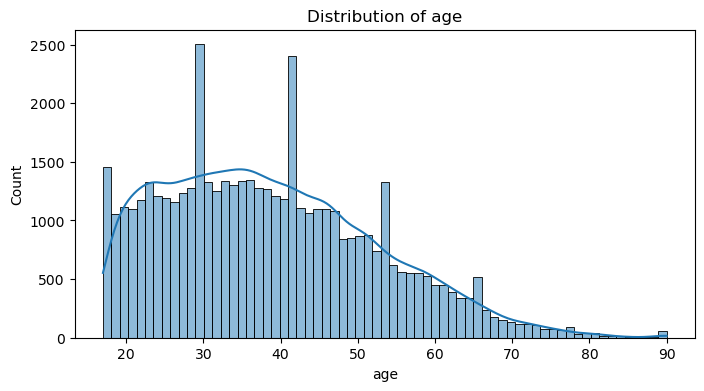

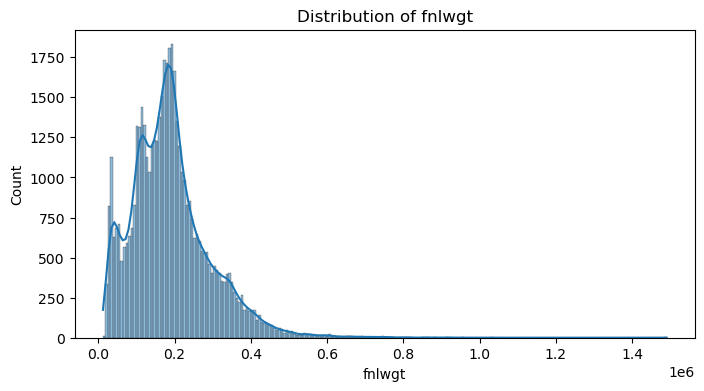

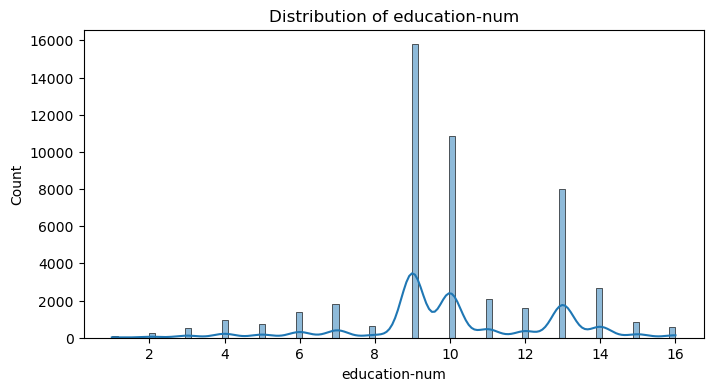

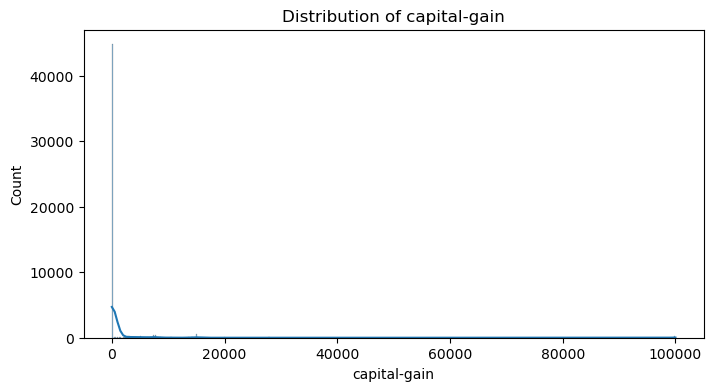

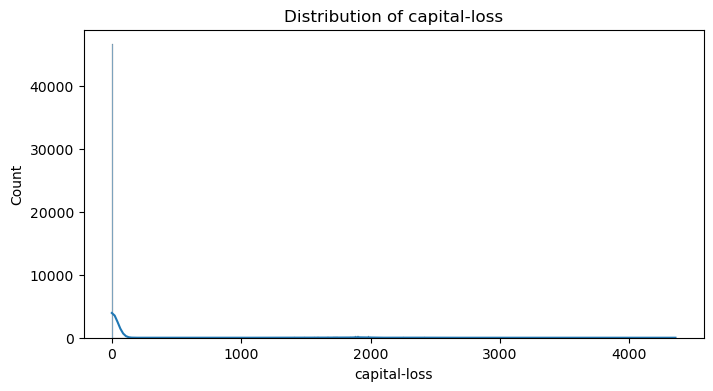

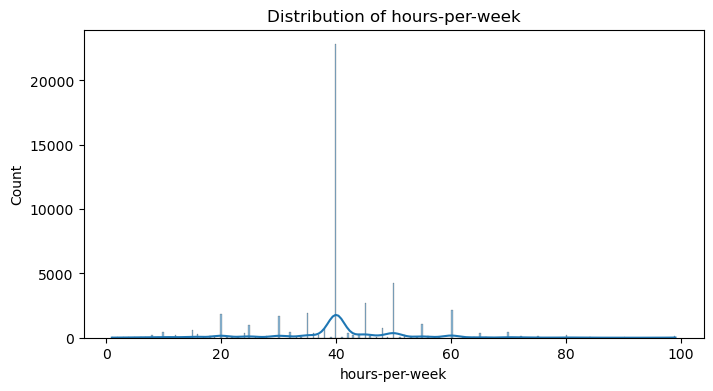

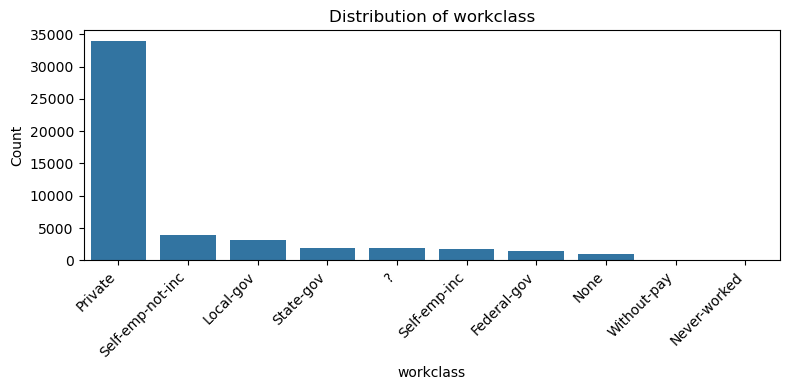

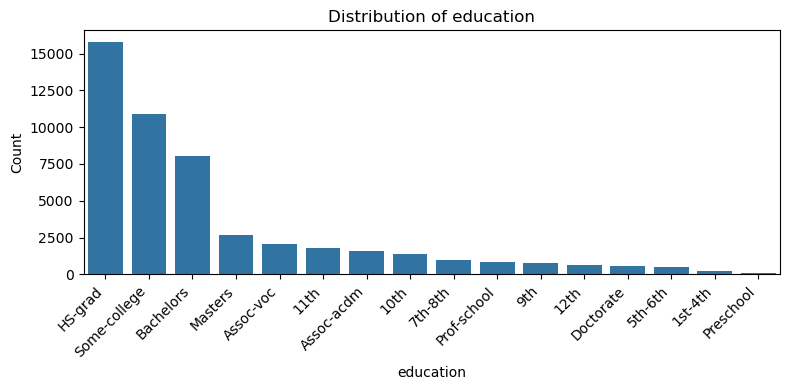

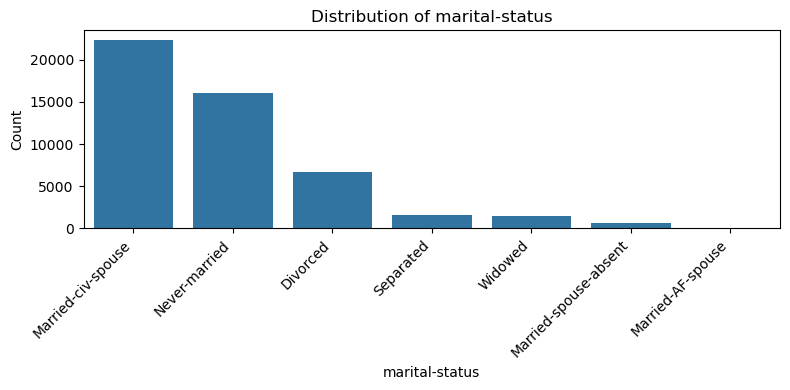

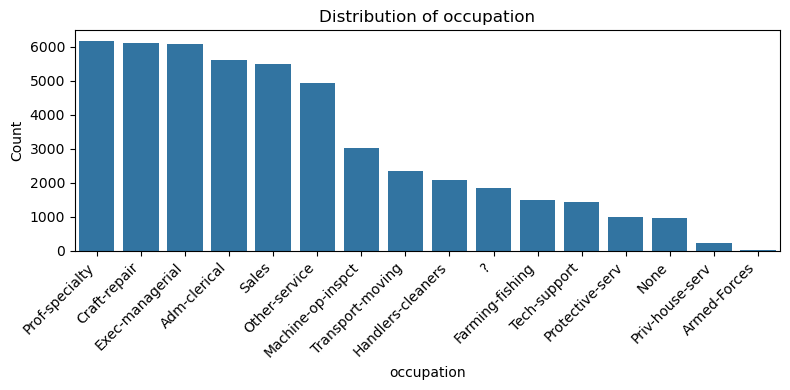

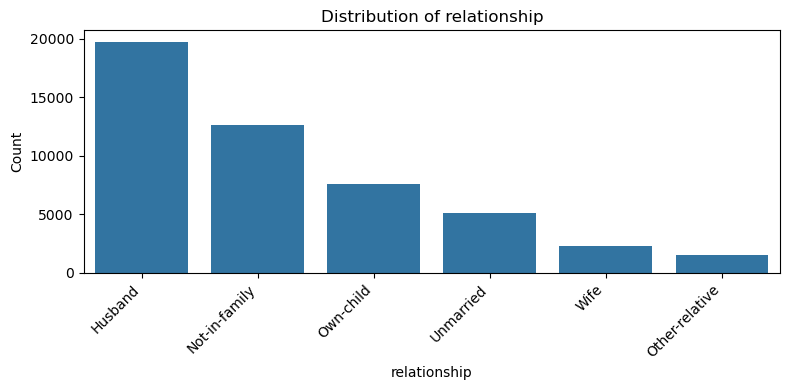

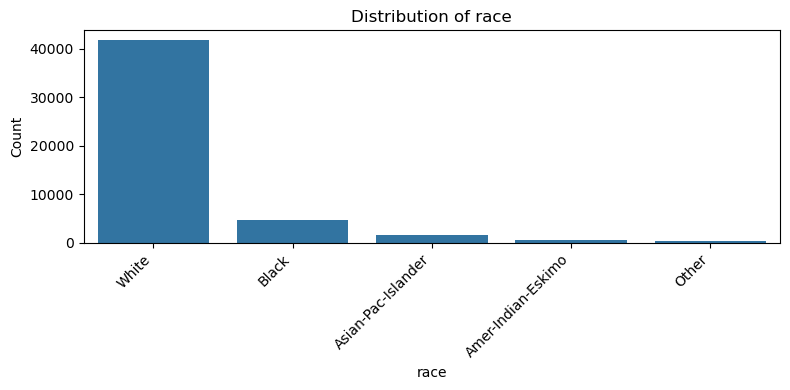

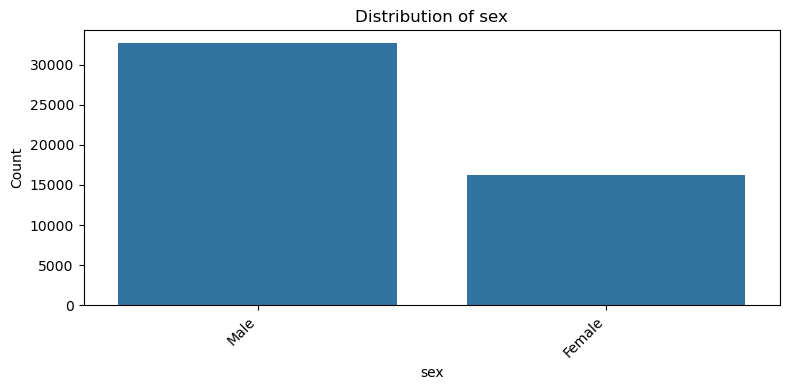

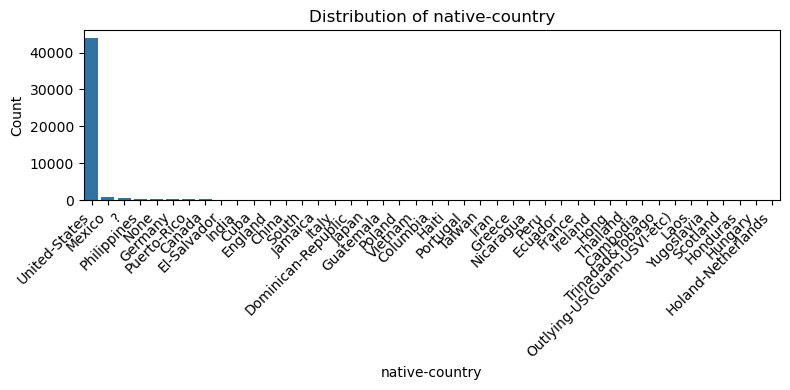

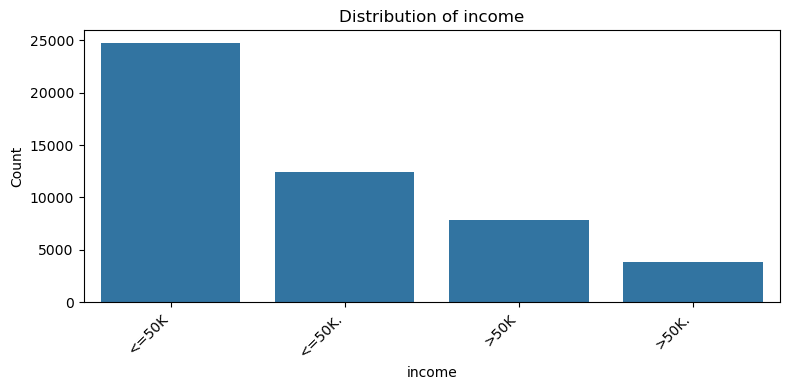

{'dtypes': Schema([('age', Int64),
         ('workclass', String),
         ('fnlwgt', Int64),
         ('education', String),
         ('education-num', Int64),
         ('marital-status', String),
         ('occupation', String),
         ('relationship', String),
         ('race', String),
         ('sex', String),
         ('capital-gain', Int64),
         ('capital-loss', Int64),
         ('hours-per-week', Int64),
         ('native-country', String),
         ('income', String)]),
 'description': shape: (9, 16)
 ┌────────────┬───────────┬────────────┬───────────┬───┬───────────┬───────────┬───────────┬────────┐
 │ statistic  ┆ age       ┆ workclass  ┆ fnlwgt    ┆ … ┆ capital-l ┆ hours-per ┆ native-co ┆ income │
 │ ---        ┆ ---       ┆ ---        ┆ ---       ┆   ┆ oss       ┆ -week     ┆ untry     ┆ ---    │
 │ str        ┆ f64       ┆ str        ┆ f64       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ str    │
 │            ┆           ┆            ┆           ┆   ┆ f64       ┆ 

In [12]:
#1. Describe your data.
eda.get_data_description(df_raw)

In [ ]:
#2. What is the distribution of the target variable?
eda.get_target_distribution(df_raw, 'income')


In [ ]:
#3. Do we face outliers and missing values?
eda.get_outliers_summary(df_raw)

### Outlier Handling Decision

Outliers detected above (particularly in `capital-gain`, `capital-loss`) represent genuine high-net-worth individuals. Removing them would bias the model against the very people we aim to detect. However, leaving them raw creates two problems:
1.  **Skew:** The extreme values (e.g., 99,999) heavily skew the distribution, which negatively impacts the GLM's convergence and performance.
2.  **Scale:** The magnitude of these values dwarfs other features like age (0-90), causing the model to disproportionately weight capital features or fail to converge.

**Strategy Chosen: Transformation (Signed Log + Scaling)**
Instead of removing or capping (Winsorising) these outliers, I handle them during the feature engineering phase of the modelling pipeline.
- I will apply a custom `SignedLogTransformer`. This compresses the massive spread of capital values while preserving zero values and the critical distinction between gains (positive) and losses (negative).

### Missing Data Imputation Strategy

The dataset contains missing values in three categorical columns: `workclass`, `occupation`, and `native_country`.

**Strategy chosen: Impute with "missing" category**

| Approach | Rationale |
|----------|-----------|
| Categorical, stays missing | Missingness may be informative e.g. someone unwilling to disclose occupation or work class could correlate with income |
| Numeric, use median | Median is robust to outliers (unlike mean). Used inside sklearn pipeline to avoid information leakage.  |

**Alternatives considered:**

| Alternative | Why rejected |
|-------------|--------------|
| Drop rows with missing values | Would lose ~7% of data; missingness may not be random, so we lose potential predictor information |
| Drop columns with missing values | Would lose whole features, again we lose potential predictor information  |

In [ ]:
# Cleaning pipeline
df_clean = cleaning.full_clean(df_raw)
df_clean.columns

In [ ]:
#4. How do specific features correlate with the target variable?
eda.get_feature_correlations(df_clean, 'high_income')

#5. What features can we use for the specific prediction task?

### Feature Selection Summary

Based on the exploratory analysis above, the following features are selected for the prediction task:

**Numeric Features:**
| Feature | Rationale |
|---------|-----------|
| `age` | Strong correlation with income; clear pattern showing income peaks mid-career |
| `education` | Ordinal encoding preserves natural ordering; higher education correlates with higher income |
| `capital_net` | Combined capital gains/losses; strong indicator of investment income |
| `hours_per_week` | Distinguishes full-time from part-time workers, as well as workers working beyond expected full-time hours |
| `is_female` | Binary encoding of sex; captures gender pay gap effects |
| `is_white`, `is_black` | Binary encoding of race; captures demographic income disparitie; This method captures three categories of race, White, Black, and Other  |
| `is_is_married_healthy` | Binary encoding of spouses together; captures value of healthy relationship |
| `age_x_education` | Help GLM recognise cross-feature correlation |

**Categorical Features:**
| Feature | Rationale |
|---------|-----------|
| `work_class` | Employment type (private, government, self-employed) affects income distribution |
| `occupation` | Strong predictor; executive and professional roles correlate with high income |
| `relationship` | Marital/household status correlates with income |
| `native_country` | May capture geographic/economic origin effects |

**Features Excluded:**
| Feature | Reason for Exclusion |
|---------|----------------------|
| `fnlwgt` | Census sampling weight; not predictive of individual income |
| `education-num` | Redundant with ordinal `education` encoding |
| `unique_id` | Artificial identifier with no predictive value |